Wczytanie wyczyszconych danych

In [1]:
import ast

import keras
import numpy as np
import pandas as pd

In [2]:
messages = pd.read_csv('../cleaned_datasets/sms_spam.csv', sep='\t', encoding='utf-8')
messages['message_clean_tokens'] = messages['message_clean_tokens'].apply(ast.literal_eval)
messages = messages.dropna(how="any", axis=0)
messages

,label,message,length,message_clean_tokens,message_clean
0,0,"Go until jurong point, crazy.. Available only ...",111,"[go, jurong, point, crazi, avail, bugi, great,...",go jurong point crazi avail bugi great world b...
1,0,Ok lar... Joking wif u oni...,29,"[ok, lar, joke, wif]",ok lar joke wif
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[free, entri, wkli, comp, win, fa, cup, final,...",free entri wkli comp win fa cup final tkts may...
3,0,U dun say so early hor... U c already then say...,49,"[dun, say, earli, hor, alreadi, say]",dun say earli hor alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,"[dont, think, goe, usf, live, around, though]",dont think goe usf live around though
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,"[time, tri, contact, å£, pound, prize, claim, ...",time tri contact å£ pound prize claim easi cal...
5568,0,Will Ì_ b going to esplanade fr home?,37,"[ì, b, go, esplanad, fr, home]",ì b go esplanad fr home
5569,0,"Pity, * was in mood for that. So...any other s...",57,"[piti, mood, soani, suggest]",piti mood soani suggest
5570,0,The guy did some bitching but I acted like i'd...,125,"[guy, bitch, act, like, id, interest, buy, som...",guy bitch act like id interest buy someth els ...


Wizualizacja tokenów

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

wiadomości nie spam

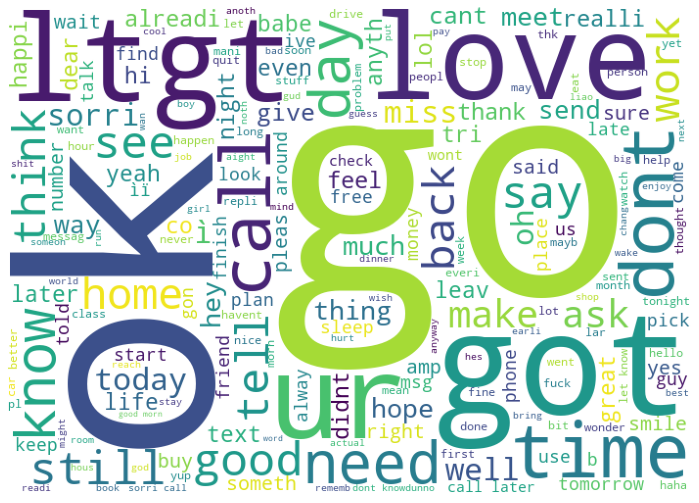

In [4]:
ham_word_cloud = WordCloud(
	width=700,
	height=500,
	background_color='white',
)
ham_word_cloud.generate(' '.join(text for text in messages.loc[messages['label'] == 0, 'message_clean']))
plt.figure(figsize=(15, 9))
plt.axis("off")
plt.imshow(ham_word_cloud)
plt.show()

wiadomości spam

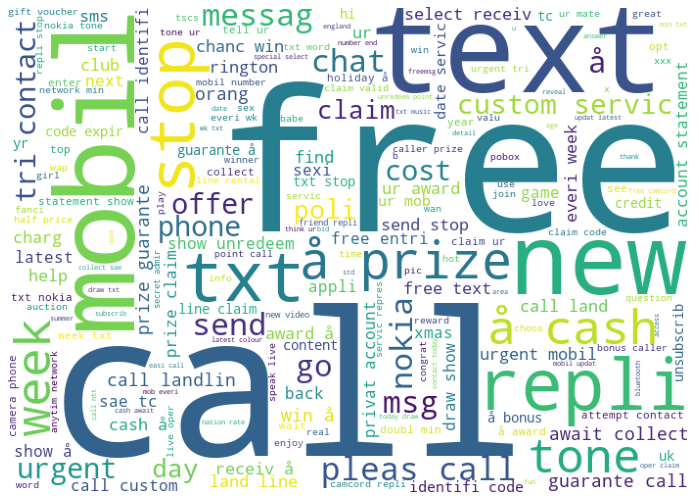

In [5]:
spam_word_cloud = WordCloud(
	width=700,
	height=500,
	background_color='white',
)
spam_word_cloud.generate(' '.join(text for text in messages.loc[messages['label'] == 1, 'message_clean']))
plt.figure(figsize=(15, 9))
plt.axis("off")
plt.imshow(spam_word_cloud)
plt.show()

Wektoryzacja

In [6]:
x = messages['message_clean']
y = messages['label']

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, stratify=y, random_state=1337)

count_vectorizer = CountVectorizer(
	stop_words='english',
	ngram_range=(1, 2),
	max_features=100
)

x_train_count_matrix = count_vectorizer.fit_transform(x_train)
x_test_count_matrix = count_vectorizer.transform(x_test)

In [8]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

x_train_tfidf = tfidf_transformer.fit_transform(x_train_count_matrix)
x_test_tfidf = tfidf_transformer.transform(x_test_count_matrix)

Modelowanie

In [23]:
# multinomial bayes

from sklearn.naive_bayes import MultinomialNB
multinomial_nb = MultinomialNB()
multinomial_nb.fit(x_train_tfidf, y_train)
y_pred_class = multinomial_nb.predict(x_test_tfidf)
y_pred_prob = multinomial_nb.predict_proba(x_test_count_matrix)[:, 1]

In [24]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))
metrics.confusion_matrix(y_test, y_pred_class)

0.9423942394239424


array([[952,  10],
       [ 54,  95]], dtype=int64)

In [25]:
# svm
from sklearn import svm
svm = svm.SVC()
svm.fit(x_train_tfidf, y_train)
y_pred_class = svm.predict(x_test_tfidf)
print(metrics.accuracy_score(y_test, y_pred_class))

0.963996399639964


In [26]:
# knn
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train_tfidf, y_train)
y_pred_class = knn.predict(x_test_tfidf)
print(metrics.accuracy_score(y_test, y_pred_class))

0.9531953195319532


Tokenizacja lstm

In [104]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(messages['message_clean'])
total_words = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(messages['message_clean'])
max_sequence_len = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(
	sequences,
	max_sequence_len,
	padding='pre'
)
x_lstm = padded_sequences
y_lstm = messages['label']
x_lstm_train, x_lstm_test, y_lstm_train, y_lstm_test = train_test_split(x_lstm, y_lstm, train_size=0.8, stratify=y_lstm, random_state=1337)

In [114]:
from keras import Sequential
from keras import layers
# lstm
model = Sequential()
model.add(layers.Embedding(input_dim=total_words, output_dim=64, input_length=max_sequence_len))
model.add(layers.BatchNormalization())
model.add(layers.LSTM(100))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [115]:
model.fit(
    x_lstm_train,
    y_lstm_train,
    epochs = 5,
    batch_size = 16,
	validation_data = (x_lstm_test, y_lstm_test),
)

Epoch 1/5
278/278 [==============================] - 11s 32ms/step - loss: 0.1389 - accuracy: 0.9577 - val_loss: 0.1865 - val_accuracy: 0.9217
Epoch 2/5
278/278 [==============================] - 8s 30ms/step - loss: 0.0240 - accuracy: 0.9921 - val_loss: 0.0748 - val_accuracy: 0.9784
Epoch 3/5
278/278 [==============================] - 10s 35ms/step - loss: 0.0073 - accuracy: 0.9977 - val_loss: 0.0700 - val_accuracy: 0.9838
Epoch 4/5
278/278 [==============================] - 9s 31ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 0.0854 - val_accuracy: 0.9811
Epoch 5/5
278/278 [==============================] - 9s 31ms/step - loss: 4.9296e-04 - accuracy: 1.0000 - val_loss: 0.0988 - val_accuracy: 0.9820


0.8613861386138614
